<a href="https://colab.research.google.com/github/danrod19/Artigo-T-cnico./blob/main/An%C3%A1lise_Reten%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nessa trabalho será realizado uma análise de dados utilizando o python, a base de dados utilizada será essa: https://www.kaggle.com/datasets/jihyeseo/online-retail-data-set-from-uci-ml-repo, esses dados dizem respeito a um e-commerce contendo as compras dos clientes

In [ ]:
import pandas as pd
retail = pd.read_excel("Online Retail.xlsx")
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Temos no dataset, na ordem da primeira à última coluna: o código numérico que identifica a compra, o código numérico que identifica o item, a descrição do item em texto, a quantidade comprada, a data da compra, o preço unitário, a chave numérica de identificaçã o do consumidor e o país da compra, o que nos permite realizar uma análise Cohort, A ideia é mapear a entrada e saída da sua base, para entender a retenção ao longo do tempo.
**A análise Cohorte trata-se uma ferramenta que permite analisar grupos em diferentes estágios e como cada um deles se relaciona com o que sua empresa propõe.**

Nesse Dataset haviam muitos dados sem a indetificação do cliente, foi necessário excluir linhas que não possuem a variável CustomerID preenchida.


In [ ]:
retail.dropna(subset=['CustomerID'], inplace=True)
#dropna() é usado para excluir linhas com valores ausentes.
#O argumento subset=['CustomerID'] indica que a remoção será feita apenas se o valor da coluna CustomerID for nulo.
#inplace=True faz a alteração diretamente no DataFrame, sem precisar atribuir o resultado a uma nova variável.

In [ ]:
retail.describe()
#Usamos o describe para gerar estatisticas descritivas do dataframe

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


a quantidade média de itens por compras é em torno de 12, enquanto a mediana indica 5, temos uma distribuição bastante assimétrica, um dos objetivos pode ser entender o consumo individual para cada cliente, podemos então contar quantos invoices cada cliente tem.

In [ ]:
retail.groupby(['CustomerID'])['InvoiceNo'].nunique().sort_values()
#groupby(['CustomerID']) → Agrupa os dados pelo ID do cliente.
#['InvoiceNo'].nunique() → Conta o número de faturas únicas (InvoiceNo) para cada cliente.
#sort_values() → Ordena o resultado em ordem crescente.

,InvoiceNo
CustomerID,
15300.0,1
13833.0,1
16123.0,1
13829.0,1
13828.0,1
...,...
13089.0,118
14606.0,128
17841.0,169


In [ ]:
invoice_per_costumer = retail.groupby(['CustomerID'])['InvoiceNo'].nunique()
invoice_per_costumer.describe()


,InvoiceNo
count,4372.000000
mean,5.075480
std,9.338754
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,248.000000


Podemos ver que há muitos clientes com poucas compras e alguns poucos com muitas compras, claramente assimétrica a distribuição de invoices pelos consumidores. Podemos ver o comportamento pelo histograma também:


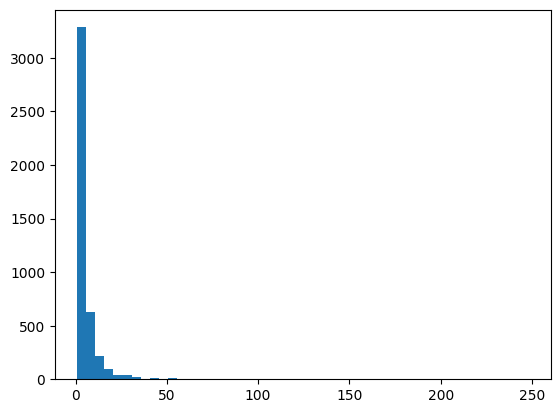

In [ ]:
import matplotlib.pyplot as plt
_ = plt.hist(invoice_per_costumer, bins=50)
# bins=50: Define que o histograma terá 50 intervalos (bins), permitindo uma visualização mais detalhada da distribuição dos dados.

Foi notado que existem consumidores com 50, 100 e até 200 compras. Mas a maioria se encontra entre 0 e 5 compras. Vamos identificar os clientes que seguem realizando compras mensalmente. Sendo assim, o agrupamento será pela chave de identificação do cliente, a chave de identificação da compra e a data da compra

In [ ]:
retail = retail[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()
#cria um novo DataFrame retail que contém apenas essas três colunas do DataFrame original e drop_duplicates() remove as linhas duplicadas

Tendo feito essa limpeza inicial, vamos começar a organizar nossas análises cohort. Como farei análises cohorts mensais, irei identificar os meses em que o cliente fez compras. Sendo assim, criei um campo para o mês da compra:

In [ ]:
retail['InvoiceMonth'] = retail['InvoiceDate'].dt.to_period('M')
#Adiciona ao DataFrame retail uma coluna chamada InvoiceMonth, para cada data em InvoiceDate, o código extrai o ano e o mês,
#formando um período (por exemplo, uma data como "2025-02-08" se torna "2025-02").

Além disso, precisamos das datas das cohorts. A cohort de cada cliente se inicia no mês em que ele entrou na base da empresa como um consumidor, ou seja, na primeira compra.

In [ ]:
retail['Cohort'] = retail.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
#Para cada grupo (ou seja, para cada cliente), ele calcula a data mínima na coluna 'InvoiceDate'. Ou seja, ele encontra a primeira fatura de cada cliente.

In [ ]:
retail.head()

,CustomerID,InvoiceNo,InvoiceDate,InvoiceMonth,Cohort
0,17850.0,536365,2010-12-01 08:26:00,2010-12,2010-12
7,17850.0,536366,2010-12-01 08:28:00,2010-12,2010-12
9,13047.0,536367,2010-12-01 08:34:00,2010-12,2010-12
21,13047.0,536368,2010-12-01 08:34:00,2010-12,2010-12
25,13047.0,536369,2010-12-01 08:35:00,2010-12,2010-12


O consumidor com a chave 17850.0 entrou na cohort de dezembro/2010, mas teve duas compras em 01/12/2010. Essas duas compras não importam muito, só é necessário identificar em quais outros momentos ele aparece. Irei contar quantos consumidores aparecem no início de cada cohort e quantos deles estão nos meses seguintes. Vou agrupar por cohort e por mes de Invoice.